# Eye for Blind – Image Captioning with Attention

# 1. Objective

Eye for Blind: An Assistive Image Captioning System with Visual Attention

This project implements a deep learning model that generates natural language descriptions of images, particularly aimed at visually impaired users. The model leverages an attention mechanism to selectively focus on image regions when generating each word, mimicking human vision.

Inspired by "Show, Attend and Tell" (Xu et al., 2015), this implementation:
1. Uses a CNN encoder (InceptionV3) to extract image features.
2. Applies additive (Bahdanau) attention during decoding.
3. Employs a decoder LSTM to generate captions.
4. Converts generated captions to speech using gTTS.

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
# 0 (default): All messages (INFO, WARNING, ERROR) are logged.
# 1: INFO messages are not printed.
# 2: INFO and WARNING messages are not printed.
# 3: INFO, WARNING, and ERROR messages are not printed.

import re
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from PIL import Image
from typing import Dict, List, Tuple, Optional
import tensorflow as tf #type: ignore
from tensorflow.keras import layers, Model #type: ignore
from tensorflow.keras.optimizers.schedules import CosineDecay #type: ignore
from tensorflow.keras.losses import SparseCategoricalCrossentropy #type: ignore
from tensorflow.keras.preprocessing.text import Tokenizer #type: ignore
from tensorflow.keras.preprocessing.sequence import pad_sequences #type: ignore
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction #type: ignore
from gtts import gTTS #type: ignore
from IPython.display import Audio, display
import tqdm

In [2]:
CONFIG = {
    # Data
    'image_dir': '/home/flickr30k_images/flickr30k_images',
    'caption_file': '/home/flickr30k_images/flickr30k_images/results.csv',
    'subset_ratio': 0.01,              # Will be overridden manually to 200 images
    'force_subset_images': 200,         # <== NEW: force subset by image count

    # Vocabulary
    'vocab_min_count': 1,               # Include all words to memorize exact text
    'max_length': 30,

    # Model Architecture
    'embedding_dim': 512,
    'units': 512,
    'decoder_dropout': 0.0,

    # Training
    'seed': 42,
    'epochs': 50,                     # High value to let it memorize
    'early_stop': True,                # Disable early stopping
    'patience': 10,
    'learning_rate': 3e-4,
    'grad_clip_value': 10.0,
    'scheduled_sampling_max_prob': 0.0, # Turn off for memorization

    # Performance
    'batch_size': 32,                   # Smaller batch for more precise updates
    'buffer_size': 10000,
    'mixed_precision': False,

    # Checkpoints
    'checkpoint_dir': './checkpoints/sanity',
    'save_checkpoints': False,
    'delete_old_checkpoints': True,

    # Attention regularizer
    'attention_reg_lambda': 1.0
}

In [3]:
# Set random seeds for reproducibility
tf.random.set_seed(CONFIG['seed'])
np.random.seed(CONFIG['seed'])
random.seed(CONFIG['seed'])

# Mixed precision policy - RTX 6000 Ada has excellent mixed precision support
if CONFIG['mixed_precision']:
    policy = tf.keras.mixed_precision.Policy('mixed_float16')
    tf.keras.mixed_precision.set_global_policy(policy)
    print("Mixed precision enabled for RTX 6000 Ada")

# Single GPU setup
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    # Enable memory growth for RTX 6000 Ada
    for gpu in physical_devices:
        tf.config.experimental.set_memory_growth(gpu, True)
    
    # Use default strategy for single GPU
    strategy = tf.distribute.get_strategy()
    print(f"Using single GPU: {physical_devices[0].name}, batch size={CONFIG['batch_size']}")
else:
    print("No GPUs found, using CPU")
    strategy = tf.distribute.get_strategy()

# Constants
AUTOTUNE = tf.data.AUTOTUNE

Using single GPU: /physical_device:GPU:0, batch size=32


In [4]:
class DataProcessor:
    def __init__(self, config):
        self.config = config
        self.captions_dict = dict()
        self.tokenizer = None
        self.vocab_size = 0
        self.train_data = []
        self.val_data = []
        self.test_data = []
    
    def load_captions(self) -> Dict[str, List[str]]:
        """Load and convert pipe-delimited Flickr-style caption file to a dict."""
        print(f"Loading captions from {self.config['caption_file']}")
        df = pd.read_csv(self.config['caption_file'], sep='|', header=None, 
                         names=['image_name', 'comment_number', 'comment'], engine='python')
        df['image_name'] = df['image_name'].str.strip()
        df['comment'] = df['comment'].str.strip()
        
        caption_map = {}
        for img, group in df.groupby('image_name'):
            caption_map[img] = group['comment'].tolist()
        
        self.captions_dict = caption_map
        print(f"Loaded {len(caption_map)} images with captions")
        return caption_map
    
    def display_samples(self, num_samples: int = 3):
        """Display random images with all their associated captions."""
        if not self.captions_dict:
            self.load_captions()

        sample_keys = random.sample(list(self.captions_dict.keys()), min(num_samples, len(self.captions_dict)))

        for key in sample_keys:
            img_path = os.path.join(self.config['image_dir'], key)
            try:
                img = Image.open(img_path)
                plt.figure(figsize=(8, 6))
                plt.imshow(img)
                plt.axis('off')
                plt.title(key)
                plt.show()

                for cap in self.captions_dict[key]:
                    print(f"- {cap}")
                print()
            except Exception as e:
                print(f"Error loading image {key}: {e}")

    def preprocess_caption(self, caption: str) -> Optional[str]:
        """Clean and format caption text."""
        if caption is None or not isinstance(caption, str):
            return None
        caption = caption.lower()
        caption = re.sub(r"[^a-z0-9.,? ]", "", caption)
        return f"<start> {caption.strip()} <end>"

    def prepare_captions(self, subset_ratio=1.0):
        """Process captions, build tokenizer & train/val/test splits."""
        if not self.captions_dict:
            self.load_captions()

        # --- 1. clean & tag ----------------------------------------------------
        all_captions = []
        for caps in self.captions_dict.values():
            for c in caps:
                p = self.preprocess_caption(c)
                if p:
                    all_captions.append(p)

        word_counts = Counter(w for cap in all_captions for w in cap.split())
        valid_words = {w for w, cnt in word_counts.items()
                    if cnt >= self.config['vocab_min_count']}

        def keep(c):
            return all(w in valid_words or w in ('<start>', '<end>') for w in c.split())

        filtered = [c for c in all_captions if keep(c)]

        # --- 2. determine max length ------------------------------------------
        lengths = [len(c.split()) for c in filtered]
        self.config['max_length'] = int(np.percentile(lengths, 95))
        print(f"max_length set to {self.config['max_length']}")

        # --- 3. build tokenizer (NO filters so < and > stay) -------------------
        tokenizer = Tokenizer(oov_token="<unk>", filters='', lower=True)
        tokenizer.fit_on_texts(filtered)
        self.tokenizer = tokenizer
        self.vocab_size = len(tokenizer.word_index) + 1
        print(f"vocab size = {self.vocab_size}")

        # --- 4. Build (image, caption) pairs ------------------------------------
        pairs = []
        for img, caps in self.captions_dict.items():
            for c in caps:
                p = self.preprocess_caption(c)
                if p and keep(p):
                    pairs.append((img, p))

        # --- 5. Force fixed number of images if requested -----------------------
        if 'force_subset_images' in self.config and self.config['force_subset_images']:
            requested = self.config['force_subset_images']
            print(f"Forcing subset of exactly {requested} images...")
            all_imgs = list({img for img, _ in pairs})
            if requested > len(all_imgs):
                raise ValueError(f"Requested {requested} images, but only {len(all_imgs)} available.")
            selected_imgs = set(random.sample(all_imgs, requested))
            pairs = [(img, cap) for img, cap in pairs if img in selected_imgs]
            print(f"Subset contains {len(pairs)} (image, caption) pairs from {requested} images.")
        
        # --- 6. Subset by ratio if no forced image count ------------------------
        elif subset_ratio < 1.0:
            orig_len = len(pairs)
            pairs = pairs[:int(len(pairs) * subset_ratio)]
            print(f"Subset by ratio: {len(pairs)} pairs from {orig_len}")

        # --- 7. Split into train/val/test ---------------------------------------
        random.shuffle(pairs)
        n = len(pairs)
        self.train_data, self.val_data, self.test_data = (
            pairs[:int(0.8 * n)],
            pairs[int(0.8 * n):int(0.9 * n)],
            pairs[int(0.9 * n):]
        )
        print(f"split → train {len(self.train_data)} | val {len(self.val_data)} | test {len(self.test_data)}")

        return filtered

        
    def encode_caption(self, caption: str) -> Tuple[np.ndarray, int]:
        """Convert caption text to sequence of token ids."""
        if self.tokenizer is None:
            raise ValueError("Tokenizer not initialized. Call prepare_captions first.")
        
        seq = self.tokenizer.texts_to_sequences([caption])[0]
        padded_seq = pad_sequences([seq], maxlen=self.config['max_length'], padding='post')[0]
        return padded_seq, len(seq)

    @tf.function(input_signature=[tf.TensorSpec([], tf.string)])
    def _base_decode(self, path: tf.Tensor) -> tf.Tensor:
        img = tf.io.read_file(path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.convert_image_dtype(img, tf.float32)          # [0,1]
        return img                                                   # (h,w,3)

    @tf.function(input_signature=[tf.TensorSpec([], tf.string)])
    def load_image_train(self, path: tf.Tensor) -> tf.Tensor:
        """Augment + preprocess (training only)."""
        img = self._base_decode(path)
        img = tf.image.random_flip_left_right(img)                   # aug ①

        # resize shorter side→342 then *random* crop 299×299
        shape = tf.shape(img)[:2]
        scale = 342. / tf.cast(tf.reduce_min(shape), tf.float32)
        new_hw = tf.cast(tf.cast(shape, tf.float32) * scale, tf.int32)
        img = tf.image.resize(img, new_hw)
        img = tf.image.random_crop(img, size=[299, 299, 3])          # aug ②

        img = tf.keras.applications.inception_v3.preprocess_input(img)
        return tf.ensure_shape(img, [299, 299, 3])

    @tf.function(input_signature=[tf.TensorSpec([], tf.string)])
    def load_image_eval(self, path: tf.Tensor) -> tf.Tensor:
        """Deterministic centre-crop (validation / inference)."""
        img = self._base_decode(path)

        # resize shorter side→342 then *central* crop 299×299
        shape = tf.shape(img)[:2]
        scale = 342. / tf.cast(tf.reduce_min(shape), tf.float32)
        new_hw = tf.cast(tf.cast(shape, tf.float32) * scale, tf.int32)
        img = tf.image.resize(img, new_hw)
        img = tf.image.resize_with_crop_or_pad(img, 299, 299)

        img = tf.keras.applications.inception_v3.preprocess_input(img)
        return tf.ensure_shape(img, [299, 299, 3])

    def data_generator(self, data):
        """
        Yield (image_tensor, token_ids, caption_len, filename)
        so the filename is always available for debug/analysis.
        """
        for img, cap in data:
            img_path  = os.path.join(self.config['image_dir'], img)
            img_tensor = self.load_image_train(tf.convert_to_tensor(img_path))
            token_ids, cap_len = self.encode_caption(cap)
            yield img_tensor, token_ids, cap_len, img 
    
    def build_dataset(self, data,
                      shuffle=True, cache=True, training: bool = True):

        output_signature = (
            tf.TensorSpec((299, 299, 3), tf.float32),               # image
            tf.TensorSpec((self.config['max_length'],), tf.int32),  # token ids
            tf.TensorSpec((), tf.int32),                            # caption len
            tf.TensorSpec((), tf.string)                            # filename
        )

        ds = tf.data.Dataset.from_generator(
            lambda: self.data_generator(data),
            output_signature=output_signature)

        if cache:
            ds = ds.cache()
        if shuffle:
            ds = ds.shuffle(self.config['buffer_size'])

        ds = ds.batch(self.config['batch_size'])
        ds = ds.prefetch(AUTOTUNE)
        return ds

    def prepare_datasets(self):
        """Prepare all datasets for training/validation/testing."""
        if not self.train_data:
            self.prepare_captions()

        print("Building datasets...")
        train_ds = self.build_dataset(self.train_data)
        val_ds = self.build_dataset(self.val_data)
        test_ds = self.build_dataset(self.test_data, shuffle=False)
        
        return train_ds, val_ds, test_ds

In [5]:
class Encoder(Model):
    """
    Inception-V3 feature extractor with an optional
    `unfreeze_top_layers()` helper for later fine-tuning.
    """
    def __init__(self):
        super().__init__(name="encoder")
        base = tf.keras.applications.InceptionV3(
            include_top=False, weights='imagenet',
            input_shape=(299, 299, 3))
        base.trainable = False                                      # phase-1: frozen
        self.cnn = Model(inputs=base.input, outputs=base.get_layer('mixed10').output)
        self.reshape = layers.Reshape((-1, 2048))                  # L=64 for 8×8 grid

    def unfreeze_top_layers(self, n: int = 2):
        """
        Fine-tune: unfreeze the last *n* Inception blocks (default: mixed9 & mixed10).
        Call **after** initial caption training for best accuracy.
        """
        for layer in self.cnn.layers[-n:]:
            layer.trainable = True

    def call(self, x):                                             # (B,299,299,3)
        x = self.cnn(x)                                            # (B,8,8,2048)
        return self.reshape(x)                                     # (B,64,2048)

In [6]:
class BahdanauAttention(layers.Layer):
    def __init__(self, units):
        super().__init__(name="attention")
        self.W1 = layers.Dense(units)
        self.W2 = layers.Dense(units)
        self.V = layers.Dense(1)
    
    def call(self, features, hidden):
        hidden_time = tf.expand_dims(hidden, 1)
        score = self.V(tf.nn.tanh(self.W1(features) + self.W2(hidden_time)))
        attention_weights = tf.nn.softmax(score, axis=1)
        context_vector = tf.reduce_sum(attention_weights * features, axis=1)
        return context_vector, tf.squeeze(attention_weights, -1)

In [7]:
class Decoder(Model):
    """
    Attention decoder with configurable dropout via config.
    """
    def __init__(self, embedding_dim: int, units: int, vocab_size: int, dropout: float = 0.5):
        super().__init__(name="decoder")
        self.units = units

        self.embedding = layers.Embedding(vocab_size, embedding_dim)
        self.attention = BahdanauAttention(units)
        self.f_beta    = layers.Dense(1, activation="sigmoid")
        self.lstm      = layers.LSTM(units, return_sequences=True, return_state=True)
        self.dropout   = layers.Dropout(dropout)

        self.deep_proj = layers.Dense(units * 2)
        self.fc        = layers.Dense(vocab_size)

    def call(self, x, features, hidden, cell):
        context, alpha = self.attention(features, hidden)
        context = self.f_beta(hidden) * context

        x = self.embedding(x)
        lstm_input = tf.concat([tf.expand_dims(context, 1), x], -1)

        hidden = tf.cast(hidden, lstm_input.dtype)
        cell   = tf.cast(cell, lstm_input.dtype)

        lstm_out, h_t, c_t = self.lstm(lstm_input, initial_state=[hidden, cell])
        lstm_out = tf.squeeze(lstm_out, 1)

        proj = self.deep_proj(tf.concat([lstm_out, context], -1))
        proj = tf.reshape(proj, (-1, self.units, 2))
        maxout = tf.reduce_max(proj, axis=-1)
        maxout = self.dropout(maxout)

        logits = self.fc(maxout)
        return tf.expand_dims(logits, 1), h_t, c_t, alpha

In [8]:
class ImageCaptioningModel:
    def __init__(self, config, processor):
        self.config          = config
        self.processor       = processor
        self.encoder         = None
        self.decoder         = None
        self.optimizer       = None
        self.loss_fn         = None
        self.ckpt_manager    = None

        self.best_bleu       = 0.0
        self.train_loss_log  = []
        self.train_bleu_log  = []
        self.val_bleu_log    = []
        self.bleu_subset_idx = None
        self.grad_norm_log = []  

        self.smoothie = SmoothingFunction().method4
    
    def build_model(self):
        """Single-GPU build with slower cosine decay."""
        print("Building model …")
        self.encoder = Encoder()
        self.decoder = Decoder(
            embedding_dim=self.config['embedding_dim'],
            units=self.config['units'],
            vocab_size=self.processor.vocab_size,
            dropout=self.config.get('decoder_dropout', 0.5)
        )

        lr_schedule = CosineDecay(
            initial_learning_rate=self.config['learning_rate'],
            decay_steps=50_000)          # stretched cosine

        self.optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
        self.loss_fn   = SparseCategoricalCrossentropy(from_logits=True,
                                                    reduction='none')

        if not self.config.get('save_checkpoints', True):
            self.ckpt_manager = None
            print("Checkpointing disabled.")
            return

        ckpt = tf.train.Checkpoint(encoder=self.encoder,
                                decoder=self.decoder,
                                optimizer=self.optimizer)
        ckpt_dir  = self.config['checkpoint_dir']
        os.makedirs(ckpt_dir, exist_ok=True)
        self.ckpt_manager = tf.train.CheckpointManager(
            ckpt, ckpt_dir,
            max_to_keep = 1 if self.config.get('delete_old_checkpoints', True) else 5)

        if self.ckpt_manager.latest_checkpoint:
            ckpt.restore(self.ckpt_manager.latest_checkpoint)
            print("Restored:", self.ckpt_manager.latest_checkpoint)
    
    def summary(self):
        """Print model summaries for Encoder, Attention, and Decoder."""
        print("Building model summaries...")

        # Dummy inputs
        dummy_image = tf.random.uniform((1, 299, 299, 3))
        dummy_features = tf.random.uniform((1, 64, 2048))
        dummy_hidden = tf.zeros((1, self.config['units']))
        dummy_cell = tf.zeros((1, self.config['units']))
        dummy_token = tf.zeros((1, 1), dtype=tf.int32)

        # --- Encoder Summary ---
        print("\nEncoder Summary:")
        self.encoder(dummy_image)
        self.encoder.summary()

        # --- Bahdanau Attention Summary ---
        print("\nBahdanau Attention Summary:")
        attention_layer = BahdanauAttention(self.config['units'])
        features_input = tf.keras.Input(shape=(64, 2048), name="features")
        hidden_input = tf.keras.Input(shape=(self.config['units'],), name="hidden")
        context_vector, attn_weights = attention_layer(features_input, hidden_input)
        attention_model = tf.keras.Model(inputs=[features_input, hidden_input], outputs=[context_vector, attn_weights])
        attention_model.summary()

        # --- Decoder Summary ---
        print("\nDecoder Summary:")
        self.decoder(dummy_token, dummy_features, dummy_hidden, dummy_cell)
        self.decoder.summary()

    @tf.function
    def train_step(self, img_tensor, target, cap_len):
        """
        Returns: (loss, grad_norm)
        """
        batch_size = tf.shape(img_tensor)[0]
        hidden     = tf.zeros((batch_size, self.config['units']))
        cell       = tf.zeros_like(hidden)

        start_tok  = self.processor.tokenizer.word_index['<start>']
        dec_input  = tf.expand_dims(tf.repeat(start_tok, batch_size), 1)

        attention_accum = None
        total_ce_loss   = 0.0

        with tf.GradientTape() as tape:
            features = self.encoder(img_tensor)

            for t in tf.range(1, self.config['max_length']):
                logits, hidden, cell, alpha = self.decoder(
                    dec_input, features, hidden, cell)

                attention_accum = (alpha if attention_accum is None
                                else attention_accum + alpha)

                ce_t  = self.loss_fn(target[:, t], tf.squeeze(logits, 1))
                mask  = tf.cast(target[:, t] > 0, tf.float32)
                total_ce_loss += tf.reduce_sum(ce_t * mask)

                pred_ids = tf.argmax(logits, -1, output_type=tf.int32)
                pred_ids = tf.squeeze(pred_ids, -1)

                ss_mask = tf.random.uniform((batch_size,)) < self.ss_prob
                next_ids = tf.where(ss_mask, pred_ids, target[:, t])
                dec_input = tf.expand_dims(next_ids, 1)

            total_tokens = tf.reduce_sum(tf.cast(cap_len, tf.float32))
            ce_loss      = total_ce_loss / total_tokens
            reg_loss     = tf.reduce_mean(tf.square(1.0 - attention_accum))
            loss         = ce_loss + self.config.get('attention_reg_lambda', 1.0) * reg_loss

        variables = self.encoder.trainable_variables + self.decoder.trainable_variables
        grads     = tape.gradient(loss, variables)
        grads, _  = tf.clip_by_global_norm(grads, self.config['grad_clip_value'])
        self.optimizer.apply_gradients(zip(grads, variables))

        grad_norm = tf.linalg.global_norm(grads)   # scalar tensor
        return loss, grad_norm

    def beam_search_decode(self,
                           image_path: str,
                           beam_size: int = 5,
                           length_penalty: float = 0.7,
                           return_attention: bool = False):
        """Beam-search with deterministic crop."""
        img_tensor = tf.expand_dims(
            self.processor.load_image_eval(tf.convert_to_tensor(image_path)), 0
        )
        base_features = self.encoder(img_tensor)       # (1,L,2048)

        start_id = self.processor.tokenizer.word_index['<start>']
        end_id   = self.processor.tokenizer.word_index['<end>']

        beams = [{'seq':[start_id],
                  'score':0.0,
                  'hidden':tf.zeros((1,self.config['units'])),
                  'cell':tf.zeros((1,self.config['units'])),
                  'alphas':[]}]

        completed = []
        for _ in range(self.config['max_length']):
            candidates = []
            for b in beams:
                last_id = b['seq'][-1]
                if last_id == end_id:
                    completed.append(b); continue
                dec_in = tf.expand_dims([last_id], 0)
                logits, h, c, alpha = self.decoder(dec_in, base_features,
                                                   b['hidden'], b['cell'])
                log_probs = tf.nn.log_softmax(logits[0,0])
                top_ids = tf.math.top_k(log_probs, k=beam_size).indices.numpy()
                for tok in top_ids:
                    tok = int(tok)
                    candidates.append({
                        'seq':   b['seq']+[tok],
                        'score': b['score']+float(log_probs[tok]),
                        'hidden':h,
                        'cell':  c,
                        'alphas':b['alphas']+[alpha[0].numpy()]})
            if not candidates: break
            def lp(b): return b['score']/(len(b['seq'])**length_penalty)
            candidates.sort(key=lp, reverse=True)
            beams = candidates[:beam_size]
            if len(completed) >= beam_size: break

        best = max(completed+beams,
                   key=lambda b: b['score']/(len(b['seq'])**length_penalty))
        words = [self.processor.tokenizer.index_word.get(i,'')
                 for i in best['seq']
                 if self.processor.tokenizer.index_word.get(i,'') not in
                 ('<start>','<end>','<unk>')]
        return (words, best['alphas']) if return_attention else words

    def greedy_decode(self, image_path: str, return_attention=False):
        """Generate caption via greedy decoding (deterministic crop)."""
        img_tensor = tf.expand_dims(
            self.processor.load_image_eval(tf.convert_to_tensor(image_path)), 0
        )

        features = self.encoder(img_tensor)
        hidden = tf.zeros((1, self.config['units']))
        cell   = tf.zeros_like(hidden)
        dec_input = tf.expand_dims(
            [self.processor.tokenizer.word_index['<start>']], 0
        )

        result, alphas = [], []
        for _ in range(self.config['max_length']):
            logits, hidden, cell, alpha = self.decoder(
                dec_input, features, hidden, cell
            )
            pred_id = tf.argmax(logits[0, 0]).numpy()
            word = self.processor.tokenizer.index_word.get(pred_id, '')
            if word == '<end>':
                break
            if word not in ('<start>', '<unk>'):
                result.append(word)
            alphas.append(alpha[0].numpy())
            dec_input = tf.expand_dims([pred_id], 0)

        return (result, alphas) if return_attention else result

    def evaluate_bleu(self, test_data, max_samples=None):
        """Calculate BLEU scores on test data."""
        refs, hyps = [], []
        data_to_eval = test_data[:max_samples] if max_samples else test_data
        
        for img_name, _ in tqdm.tqdm(data_to_eval):
            image_path = os.path.join(self.config['image_dir'], img_name)
            hyp = self.greedy_decode(image_path)
            
            # Process ground truth captions
            gt = [self.processor.preprocess_caption(c).split() for c in self.processor.captions_dict[img_name][:5]]
            gt = [[w for w in cap if w not in ('<start>', '<end>')] for cap in gt]
            
            refs.append(gt)
            hyps.append(hyp)
        
        # Calculate BLEU scores for different n-grams
        bleu_scores = {}
        for i in range(1, 5):
            weights = tuple([1.0/i]*i + [0.0]*(4-i))
            score = corpus_bleu(refs, hyps, weights=weights, smoothing_function=self.smoothie)
            bleu_scores[f'bleu-{i}'] = score
            print(f"BLEU-{i}: {score:.4f}")
        
        return bleu_scores
    
    def train(self, train_ds, val_data, epochs=None, subset_size: int = 200, bleu_check = False):
        """
        Train the captioning model, now logging gradient norms every batch.
        """

        # ── 0. setup ─────────────────────────────────────────────────────────
        if epochs is None:
            epochs = self.config['epochs']

        if self.bleu_subset_idx is None:
            total_train = len(self.processor.train_data)
            subset_size = min(subset_size, total_train)
            self.bleu_subset_idx = random.sample(range(total_train), subset_size)

        def _subset(data, idx):
            return [data[i] for i in idx]

        patience          = self.config.get('patience', 8)
        wait              = 0
        apply_early_stop  = self.config.get('early_stop', True)
        self.ss_max_prob  = self.config.get('scheduled_sampling_max_prob', 0.0)

        # clear grad-norm history for a fresh plot
        self.grad_norm_log = []

        # ── 1. epoch loop ────────────────────────────────────────────────────
        for epoch in range(epochs):
            self.ss_prob = self.ss_max_prob * (epoch / max(1, epochs - 1))
            print(f"\nEpoch {epoch+1}/{epochs}  (ε={self.ss_prob:.3f})")

            start_time      = time.time()
            total_loss      = 0.0
            latest_grad_norm = 0.0

            prog = tf.keras.utils.Progbar(None, stateful_metrics=['loss'])

            # ── 1.1 batch loop ───────────────────────────────────────────────
            for batch, (img, tgt, cap_len, _) in enumerate(train_ds):
                if batch == 0 and prog.target is None:
                    # rough number of batches for nice progress bar scaling
                    prog.target = len(self.processor.train_data) // self.config['batch_size'] + 1
                
                batch_loss, batch_norm = self.train_step(img, tgt, cap_len)

                # Convert EagerTensors to Python floats for safe math / logging
                total_loss       += batch_loss.numpy()
                latest_grad_norm  = batch_norm.numpy()
                self.grad_norm_log.append(latest_grad_norm)

                prog.update(batch + 1, values=[('loss', batch_loss)])

            avg_loss = total_loss / (batch + 1)
            self.train_loss_log.append(avg_loss)

            print(f"Grad-norm (last step): {latest_grad_norm:.2f}")

            # ── 1.2 quick BLEU checks ───────────────────────────────────────
            train_subset = _subset(self.processor.train_data, self.bleu_subset_idx)
            train_bleu   = self.evaluate_bleu(train_subset)['bleu-4']
            val_bleu     = self.evaluate_bleu(val_data)['bleu-4']
            self.train_bleu_log.append(train_bleu)
            self.val_bleu_log.append(val_bleu)

            # ── 1.3 checkpoint ──────────────────────────────────────────────
            if self.ckpt_manager:
                self.ckpt_manager.save()

            # ── 1.4 early-stopping ──────────────────────────────────────────
            if val_bleu > self.best_bleu:
                self.best_bleu = val_bleu
                wait = 0
            else:
                wait += 1
                if apply_early_stop and wait >= patience:
                    print(f"Early stopping (no BLEU gain for {wait} epochs)")
                    break

            # current learning-rate
            lr_now = float(self.optimizer.learning_rate(self.optimizer.iterations).numpy())

            print(f"Epoch {epoch+1}: "
                f"loss={avg_loss:.4f}  "
                f"trainBLEU={train_bleu:.4f}  valBLEU={val_bleu:.4f}  "
                f"lr={lr_now:.2e}  "
                f"time={time.time() - start_time:.1f}s")

        return self.train_loss_log, self.val_bleu_log
    
    def plot_attention(self, image_path: str, caption: list, alphas: list):
        """Improved visualization of attention with better contrast and 299x299 alignment."""
        img = np.array(Image.open(image_path).resize((299, 299)))
        fig = plt.figure(figsize=(15, 8))

        for t in range(len(caption)):
            ax = fig.add_subplot(3, int(np.ceil(len(caption) / 3)), t + 1)
            ax.imshow(img)
            ax.axis('off')

            alpha = np.array(alphas[t])
            attention_shape = int(np.sqrt(alpha.size))
            alpha = alpha.reshape((attention_shape, attention_shape))

            # Normalize and boost contrast
            alpha -= alpha.min()
            if alpha.max() > 0:
                alpha /= alpha.max()

            # Resize attention map to 299×299
            alpha_resized = Image.fromarray(np.uint8(255 * alpha)).resize((299, 299), resample=Image.BICUBIC)
            alpha_resized = np.array(alpha_resized) / 255.0  # back to [0,1] float

            ax.imshow(alpha_resized, cmap='jet', alpha=0.5, extent=(0, 299, 299, 0))
            ax.set_title(f"{t+1}: '{caption[t]}'", fontsize=10)

        plt.tight_layout()
        plt.show()

    def plot_history(self):
        """Plot loss curve **and** both train/val BLEU-4 curves."""
        plt.figure(figsize=(14, 5))

        # --- left: training loss ---
        plt.subplot(1, 2, 1)
        plt.plot(self.train_loss_log, label='Train Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Cross-Entropy Loss')
        plt.title('Training Loss')
        plt.grid(True)
        plt.legend()

        # --- right: BLEU-4 ---
        plt.subplot(1, 2, 2)
        if self.train_bleu_log:
            plt.plot(self.train_bleu_log, label='Train BLEU-4')
        plt.plot(self.val_bleu_log,   label='Val BLEU-4')
        plt.xlabel('Epoch')
        plt.ylabel('BLEU-4')
        plt.title('BLEU-4 Scores')
        plt.grid(True)
        plt.legend()

        plt.tight_layout()
        plt.show()
    
    def speak_caption(self, caption: str, filename="caption_audio.mp3"):
        """Generate speech audio from caption text."""
        if not caption:
            print("Empty caption, nothing to speak")
            return
            
        tts = gTTS(text=caption, lang='en')
        tts.save(filename)
        display(Audio(filename))
        print(f"Audio saved to {filename}")
    
    def demo(
            self,
            image_path: str,
            filename: str = "caption_audio.mp3",
            beam_size: int = 5,
            length_penalty: float = 0.7):
        """
        End-to-end demo (beam-search inference):

        1. Original image  – now titled with the **filename**
        2. Ground-truth captions
        3. Generated caption
        4. Audio playback
        5. Attention heat-maps
        """
        if not os.path.exists(image_path):
            print(f"Image not found: {image_path}")
            return

        # ---------------- 1. original image ----------------
        img_name = os.path.basename(image_path)              # <- filename for the title
        img = Image.open(image_path)

        plt.figure(figsize=(8, 6))
        plt.imshow(img)
        plt.title(img_name, fontsize=14, pad=10)             # <- show filename here
        plt.axis('off')
        plt.show()

        # ---------------- 2. ground-truth captions ----------
        gt_caps = self.processor.captions_dict.get(img_name, [])
        if gt_caps:
            print("Ground-truth captions:")
            for cap in gt_caps:
                print(" -", cap)
        else:
            print("No ground-truth captions found.")

        # ---------------- 3. caption generation -------------
        words, attention = self.beam_search_decode(
            image_path,
            beam_size=beam_size,
            length_penalty=length_penalty,
            return_attention=True
        )
        caption = " ".join(words)
        print("\nGenerated caption:")
        print(caption)

        # ---------------- 4. audio --------------------------
        self.speak_caption(caption, filename=filename)

        # ---------------- 5. attention plot ----------------
        self.plot_attention(image_path, words, attention)


    def prime_dataset(self, ds, steps: int = None) -> None:
        """
        Pre-fill a tf.data shuffle buffer so the first training epoch
        starts without the usual “Filling up shuffle buffer …” pause.

        Args
        ----
        ds    : the *un-iterated* tf.data.Dataset you’ll pass to train()
        steps : number of iterator steps to advance; default uses
                buffer_size // batch_size + 1 from config.
        """
        if steps is None:
            steps = self.config['buffer_size'] // self.config['batch_size'] + 1

        it = iter(ds)
        for _ in range(steps):
            try:
                next(it)
            except StopIteration:  # dataset shorter than requested priming
                break

    def fine_tune_cnn(self,
                      train_ds,
                      val_data,
                      layers_to_unfreeze: int = 2,
                      lr: float = 1e-5,
                      epochs: int = 1):
        """
        Phase-2 fine-tuning of the top Inception blocks.
        Call after initial caption training for an extra accuracy bump.
        """
        print(f"\nUnfreezing top {layers_to_unfreeze} Inception blocks …")
        self.encoder.unfreeze_top_layers(layers_to_unfreeze)

        # New, low learning-rate optimiser
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

        print(f"Fine-tuning CNN for {epochs} epoch(s) at lr={lr} …")
        self.train(train_ds, val_data, epochs=epochs)

        print("CNN fine-tune finished.")


    def plot_grad_norms(self):
        """Simple line plot of gradient norms per batch."""
        if not self.grad_norm_log:
            print("No grad-norm data logged yet.")
            return
        plt.figure(figsize=(8,4))
        plt.plot(self.grad_norm_log)
        plt.xlabel('Update step')
        plt.ylabel('Global grad norm')
        plt.title('Gradient-norm trajectory')
        plt.grid(True)
        plt.show()

In [9]:
processor = DataProcessor(CONFIG)

In [10]:
_ = processor.load_captions()

Loading captions from /home/flickr30k_images/flickr30k_images/results.csv
Loaded 31784 images with captions


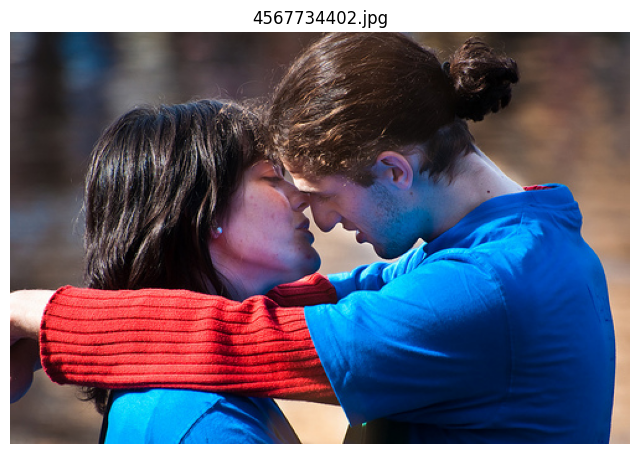

- A man in a blue and red shirt hugs a woman in a blue top .
- A man and a woman are about to kiss .
- A woman and a man getting closer .
- A couple that is about to kiss .
- Two young people are kissing .



In [11]:
processor.display_samples(1)

In [12]:
processor.prepare_captions(subset_ratio=CONFIG['subset_ratio'])[:20]

max_length set to 25
vocab size = 20062
Forcing subset of exactly 200 images...
Subset contains 1000 (image, caption) pairs from 200 images.
split → train 800 | val 100 | test 100


['<start> two young guys with shaggy hair look at their hands while hanging out in the yard . <end>',
 '<start> two young , white males are outside near many bushes . <end>',
 '<start> two men in green shirts are standing in a yard . <end>',
 '<start> a man in a blue shirt standing in a garden . <end>',
 '<start> two friends enjoy time spent together . <end>',
 '<start> several men in hard hats are operating a giant pulley system . <end>',
 '<start> workers look down from up above on a piece of equipment . <end>',
 '<start> two men working on a machine wearing hard hats . <end>',
 '<start> four men on top of a tall structure . <end>',
 '<start> three men on a large rig . <end>',
 '<start> a child in a pink dress is climbing up a set of stairs in an entry way . <end>',
 '<start> a little girl in a pink dress going into a wooden cabin . <end>',
 '<start> a little girl climbing the stairs to her playhouse . <end>',
 '<start> a little girl climbing into a wooden playhouse <end>',
 '<start>

In [13]:
# Create datasets
train_ds, val_ds, _ = processor.prepare_datasets()

Building datasets...


In [14]:
model = ImageCaptioningModel(CONFIG, processor)
model.build_model()

Building model …
Checkpointing disabled.


In [15]:
model.summary()

Building model summaries...

Encoder Summary:
Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 8, 8, 2048)        21802784  
                                                                 
 reshape (Reshape)           multiple                  0         
                                                                 
Total params: 21,802,784
Trainable params: 0
Non-trainable params: 21,802,784
_________________________________________________________________

Bahdanau Attention Summary:
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 features (InputLayer)          [(None, 64, 2048)]   0           []                               
                                                      

In [16]:
model.prime_dataset(train_ds, steps=20)

In [18]:
reduced_val = random.sample(processor.val_data, min(len(processor.val_data), 10))

In [19]:
model.prime_dataset(ds=train_ds, steps=50)

In [28]:
# model.train(train_ds, processor.val_data)
model.train(train_ds=train_ds, val_data=reduced_val)


Epoch 1/50  (ε=0.000)
25/26 [===========================>..] - ETA: 0s - loss: 5.1232Grad-norm (last step): 1.65


100%|██████████| 200/200 [00:34<00:00,  5.73it/s]


BLEU-1: 0.3142
BLEU-2: 0.0120
BLEU-3: 0.0034
BLEU-4: 0.0016


100%|██████████| 10/10 [00:01<00:00,  5.76it/s]


BLEU-1: 0.3067
BLEU-2: 0.0411
BLEU-3: 0.0175
BLEU-4: 0.0100
Epoch 1: loss=5.3000  trainBLEU=0.0016  valBLEU=0.0100  lr=3.00e-04  time=40.4s

Epoch 2/50  (ε=0.000)
25/26 [===========================>..] - ETA: 0s - loss: 5.0711Grad-norm (last step): 1.97


100%|██████████| 200/200 [00:39<00:00,  5.11it/s]


BLEU-1: 0.3565
BLEU-2: 0.0118
BLEU-3: 0.0031
BLEU-4: 0.0014


100%|██████████| 10/10 [00:01<00:00,  5.04it/s]


BLEU-1: 0.3423
BLEU-2: 0.0400
BLEU-3: 0.0160
BLEU-4: 0.0088
Epoch 2: loss=5.0965  trainBLEU=0.0014  valBLEU=0.0088  lr=3.00e-04  time=44.9s

Epoch 3/50  (ε=0.000)
25/26 [===========================>..] - ETA: 0s - loss: 4.9376Grad-norm (last step): 1.87


100%|██████████| 200/200 [00:49<00:00,  4.03it/s]


BLEU-1: 0.2350
BLEU-2: 0.0078
BLEU-3: 0.0021
BLEU-4: 0.0009


100%|██████████| 10/10 [00:02<00:00,  3.82it/s]

BLEU-1: 0.2099
BLEU-2: 0.0253
BLEU-3: 0.0101
BLEU-4: 0.0055
Epoch 3: loss=4.9608  trainBLEU=0.0009  valBLEU=0.0055  lr=3.00e-04  time=56.1s

Epoch 4/50  (ε=0.000)
 1/26 [>.............................] - ETA: 3s - loss: 4.8728

25/26 [===========================>..] - ETA: 0s - loss: 4.8442Grad-norm (last step): 1.57


100%|██████████| 200/200 [01:04<00:00,  3.12it/s]


BLEU-1: 0.1412
BLEU-2: 0.0498
BLEU-3: 0.0077
BLEU-4: 0.0026


100%|██████████| 10/10 [00:03<00:00,  3.17it/s]

BLEU-1: 0.1434
BLEU-2: 0.0495
BLEU-3: 0.0182
BLEU-4: 0.0094
Epoch 4: loss=4.8077  trainBLEU=0.0026  valBLEU=0.0094  lr=3.00e-04  time=71.0s

Epoch 5/50  (ε=0.000)
 1/26 [>.............................] - ETA: 3s - loss: 4.6561

25/26 [===========================>..] - ETA: 0s - loss: 4.6374Grad-norm (last step): 1.66


100%|██████████| 200/200 [01:02<00:00,  3.18it/s]


BLEU-1: 0.2274
BLEU-2: 0.1254
BLEU-3: 0.0676
BLEU-4: 0.0408


100%|██████████| 10/10 [00:03<00:00,  3.09it/s]

BLEU-1: 0.2120
BLEU-2: 0.1030
BLEU-3: 0.0569
BLEU-4: 0.0303
Epoch 5: loss=4.6142  trainBLEU=0.0408  valBLEU=0.0303  lr=3.00e-04  time=69.9s

Epoch 6/50  (ε=0.000)
 1/26 [>.............................] - ETA: 3s - loss: 4.5587

25/26 [===========================>..] - ETA: 0s - loss: 4.3824Grad-norm (last step): 3.29


100%|██████████| 200/200 [01:04<00:00,  3.11it/s]


BLEU-1: 0.2488
BLEU-2: 0.1220
BLEU-3: 0.0655
BLEU-4: 0.0395


100%|██████████| 10/10 [00:03<00:00,  3.05it/s]

BLEU-1: 0.2480
BLEU-2: 0.1114
BLEU-3: 0.0600
BLEU-4: 0.0315
Epoch 6: loss=4.4474  trainBLEU=0.0395  valBLEU=0.0315  lr=3.00e-04  time=71.4s

Epoch 7/50  (ε=0.000)
 1/26 [>.............................] - ETA: 3s - loss: 4.2734

25/26 [===========================>..] - ETA: 0s - loss: 3.9480Grad-norm (last step): 1.85


100%|██████████| 200/200 [00:54<00:00,  3.65it/s]


BLEU-1: 0.3081
BLEU-2: 0.1535
BLEU-3: 0.0839
BLEU-4: 0.0512


100%|██████████| 10/10 [00:02<00:00,  3.55it/s]

BLEU-1: 0.2772
BLEU-2: 0.1316
BLEU-3: 0.0725
BLEU-4: 0.0386
Epoch 7: loss=4.2913  trainBLEU=0.0512  valBLEU=0.0386  lr=3.00e-04  time=61.4s

Epoch 8/50  (ε=0.000)
 1/26 [>.............................] - ETA: 3s - loss: 4.1884

25/26 [===========================>..] - ETA: 0s - loss: 4.0358Grad-norm (last step): 2.09


100%|██████████| 200/200 [01:03<00:00,  3.15it/s]


BLEU-1: 0.2396
BLEU-2: 0.1348
BLEU-3: 0.0712
BLEU-4: 0.0421


100%|██████████| 10/10 [00:03<00:00,  3.13it/s]

BLEU-1: 0.2200
BLEU-2: 0.1049
BLEU-3: 0.0576
BLEU-4: 0.0305
Epoch 8: loss=4.1562  trainBLEU=0.0421  valBLEU=0.0305  lr=3.00e-04  time=70.4s

Epoch 9/50  (ε=0.000)
 1/26 [>.............................] - ETA: 3s - loss: 4.1329

25/26 [===========================>..] - ETA: 0s - loss: 3.9525Grad-norm (last step): 1.77


100%|██████████| 200/200 [00:52<00:00,  3.84it/s]


BLEU-1: 0.3910
BLEU-2: 0.2126
BLEU-3: 0.1114
BLEU-4: 0.0648


100%|██████████| 10/10 [00:02<00:00,  3.80it/s]

BLEU-1: 0.3529
BLEU-2: 0.1610
BLEU-3: 0.0853
BLEU-4: 0.0446
Epoch 9: loss=4.0330  trainBLEU=0.0648  valBLEU=0.0446  lr=3.00e-04  time=58.5s

Epoch 10/50  (ε=0.000)
 1/26 [>.............................] - ETA: 3s - loss: 3.9492

25/26 [===========================>..] - ETA: 0s - loss: 3.7345Grad-norm (last step): 2.27


100%|██████████| 200/200 [00:53<00:00,  3.72it/s]


BLEU-1: 0.3296
BLEU-2: 0.1782
BLEU-3: 0.0964
BLEU-4: 0.0580


100%|██████████| 10/10 [00:02<00:00,  3.69it/s]

BLEU-1: 0.3089
BLEU-2: 0.1431
BLEU-3: 0.0782
BLEU-4: 0.0415
Epoch 10: loss=3.9175  trainBLEU=0.0580  valBLEU=0.0415  lr=3.00e-04  time=60.2s

Epoch 11/50  (ε=0.000)
 1/26 [>.............................] - ETA: 3s - loss: 3.8527

25/26 [===========================>..] - ETA: 0s - loss: 4.0353Grad-norm (last step): 1.83


100%|██████████| 200/200 [00:49<00:00,  4.03it/s]


BLEU-1: 0.4432
BLEU-2: 0.2429
BLEU-3: 0.1282
BLEU-4: 0.0693


100%|██████████| 10/10 [00:02<00:00,  3.92it/s]

BLEU-1: 0.4205
BLEU-2: 0.2251
BLEU-3: 0.1175
BLEU-4: 0.0577
Epoch 11: loss=3.8125  trainBLEU=0.0693  valBLEU=0.0577  lr=3.00e-04  time=56.0s

Epoch 12/50  (ε=0.000)
 1/26 [>.............................] - ETA: 3s - loss: 3.6580

25/26 [===========================>..] - ETA: 0s - loss: 3.8069Grad-norm (last step): 2.75


100%|██████████| 200/200 [00:59<00:00,  3.34it/s]


BLEU-1: 0.3108
BLEU-2: 0.1745
BLEU-3: 0.1028
BLEU-4: 0.0615


100%|██████████| 10/10 [00:03<00:00,  3.26it/s]

BLEU-1: 0.2712
BLEU-2: 0.1296
BLEU-3: 0.0678
BLEU-4: 0.0351
Epoch 12: loss=3.7303  trainBLEU=0.0615  valBLEU=0.0351  lr=3.00e-04  time=66.8s

Epoch 13/50  (ε=0.000)
 1/26 [>.............................] - ETA: 3s - loss: 3.7326

25/26 [===========================>..] - ETA: 0s - loss: 3.5984Grad-norm (last step): 1.71


100%|██████████| 200/200 [00:43<00:00,  4.63it/s]


BLEU-1: 0.5547
BLEU-2: 0.3141
BLEU-3: 0.1803
BLEU-4: 0.1086


100%|██████████| 10/10 [00:02<00:00,  4.33it/s]

BLEU-1: 0.4932
BLEU-2: 0.2315
BLEU-3: 0.1188
BLEU-4: 0.0614
Epoch 13: loss=3.6508  trainBLEU=0.1086  valBLEU=0.0614  lr=3.00e-04  time=49.4s

Epoch 14/50  (ε=0.000)
 1/26 [>.............................] - ETA: 4s - loss: 3.6531

25/26 [===========================>..] - ETA: 0s - loss: 3.6922Grad-norm (last step): 2.55


100%|██████████| 200/200 [00:54<00:00,  3.69it/s]


BLEU-1: 0.4030
BLEU-2: 0.2223
BLEU-3: 0.1255
BLEU-4: 0.0763


100%|██████████| 10/10 [00:02<00:00,  3.41it/s]

BLEU-1: 0.3425
BLEU-2: 0.1568
BLEU-3: 0.0791
BLEU-4: 0.0402
Epoch 14: loss=3.5781  trainBLEU=0.0763  valBLEU=0.0402  lr=3.00e-04  time=61.0s

Epoch 15/50  (ε=0.000)
 1/26 [>.............................] - ETA: 3s - loss: 3.4925

25/26 [===========================>..] - ETA: 0s - loss: 3.4880Grad-norm (last step): 1.96


100%|██████████| 200/200 [00:59<00:00,  3.38it/s]


BLEU-1: 0.3389
BLEU-2: 0.1853
BLEU-3: 0.1037
BLEU-4: 0.0635


100%|██████████| 10/10 [00:03<00:00,  3.21it/s]

BLEU-1: 0.2798
BLEU-2: 0.1297
BLEU-3: 0.0671
BLEU-4: 0.0345
Epoch 15: loss=3.4963  trainBLEU=0.0635  valBLEU=0.0345  lr=3.00e-04  time=66.2s

Epoch 16/50  (ε=0.000)
 1/26 [>.............................] - ETA: 3s - loss: 3.4560

25/26 [===========================>..] - ETA: 0s - loss: 3.5316Grad-norm (last step): 2.15


100%|██████████| 200/200 [00:39<00:00,  5.08it/s]


BLEU-1: 0.5334
BLEU-2: 0.2898
BLEU-3: 0.1501
BLEU-4: 0.0796


100%|██████████| 10/10 [00:02<00:00,  4.77it/s]

BLEU-1: 0.4922
BLEU-2: 0.2237
BLEU-3: 0.1228
BLEU-4: 0.0659
Epoch 16: loss=3.4203  trainBLEU=0.0796  valBLEU=0.0659  lr=3.00e-04  time=45.3s

Epoch 17/50  (ε=0.000)
 1/26 [>.............................] - ETA: 3s - loss: 3.3088

25/26 [===========================>..] - ETA: 0s - loss: 3.5010Grad-norm (last step): 2.35


100%|██████████| 200/200 [00:47<00:00,  4.21it/s]


BLEU-1: 0.3774
BLEU-2: 0.2013
BLEU-3: 0.0964
BLEU-4: 0.0491


100%|██████████| 10/10 [00:02<00:00,  4.26it/s]


BLEU-1: 0.4094
BLEU-2: 0.2102
BLEU-3: 0.1009
BLEU-4: 0.0456
Epoch 17: loss=3.3604  trainBLEU=0.0491  valBLEU=0.0456  lr=3.00e-04  time=53.7s

Epoch 18/50  (ε=0.000)
25/26 [===========================>..] - ETA: 0s - loss: 3.3364Grad-norm (last step): 2.28


100%|██████████| 200/200 [00:46<00:00,  4.33it/s]


BLEU-1: 0.5262
BLEU-2: 0.2981
BLEU-3: 0.1723
BLEU-4: 0.1048


100%|██████████| 10/10 [00:02<00:00,  4.42it/s]

BLEU-1: 0.4861
BLEU-2: 0.2409
BLEU-3: 0.1233
BLEU-4: 0.0637
Epoch 18: loss=3.2976  trainBLEU=0.1048  valBLEU=0.0637  lr=3.00e-04  time=52.3s

Epoch 19/50  (ε=0.000)
 1/26 [>.............................] - ETA: 3s - loss: 3.1307

25/26 [===========================>..] - ETA: 0s - loss: 3.1741Grad-norm (last step): 3.21


100%|██████████| 200/200 [00:44<00:00,  4.47it/s]


BLEU-1: 0.4794
BLEU-2: 0.2691
BLEU-3: 0.1541
BLEU-4: 0.0902


100%|██████████| 10/10 [00:02<00:00,  4.34it/s]

BLEU-1: 0.4459
BLEU-2: 0.2202
BLEU-3: 0.1148
BLEU-4: 0.0599
Epoch 19: loss=3.2271  trainBLEU=0.0902  valBLEU=0.0599  lr=3.00e-04  time=50.9s

Epoch 20/50  (ε=0.000)
 1/26 [>.............................] - ETA: 3s - loss: 3.0118

25/26 [===========================>..] - ETA: 0s - loss: 3.1177Grad-norm (last step): 1.81


100%|██████████| 200/200 [00:35<00:00,  5.60it/s]


BLEU-1: 0.5841
BLEU-2: 0.3271
BLEU-3: 0.1850
BLEU-4: 0.1072


100%|██████████| 10/10 [00:01<00:00,  5.74it/s]


BLEU-1: 0.5882
BLEU-2: 0.3008
BLEU-3: 0.1699
BLEU-4: 0.0939
Epoch 20: loss=3.1563  trainBLEU=0.1072  valBLEU=0.0939  lr=3.00e-04  time=41.2s

Epoch 21/50  (ε=0.000)
25/26 [===========================>..] - ETA: 0s - loss: 3.2869Grad-norm (last step): 2.81


100%|██████████| 200/200 [00:39<00:00,  5.02it/s]


BLEU-1: 0.5796
BLEU-2: 0.3283
BLEU-3: 0.1831
BLEU-4: 0.1084


100%|██████████| 10/10 [00:01<00:00,  5.04it/s]

BLEU-1: 0.5536
BLEU-2: 0.2656
BLEU-3: 0.1565
BLEU-4: 0.0827
Epoch 21: loss=3.0905  trainBLEU=0.1084  valBLEU=0.0827  lr=3.00e-04  time=45.6s

Epoch 22/50  (ε=0.000)
 1/26 [>.............................] - ETA: 3s - loss: 2.9953

25/26 [===========================>..] - ETA: 0s - loss: 3.1461Grad-norm (last step): 2.92


100%|██████████| 200/200 [00:44<00:00,  4.50it/s]


BLEU-1: 0.5141
BLEU-2: 0.2941
BLEU-3: 0.1765
BLEU-4: 0.1086


100%|██████████| 10/10 [00:02<00:00,  4.35it/s]

BLEU-1: 0.4452
BLEU-2: 0.1982
BLEU-3: 0.0978
BLEU-4: 0.0533
Epoch 22: loss=3.0350  trainBLEU=0.1086  valBLEU=0.0533  lr=3.00e-04  time=50.5s

Epoch 23/50  (ε=0.000)
 1/26 [>.............................] - ETA: 3s - loss: 2.8366

25/26 [===========================>..] - ETA: 0s - loss: 3.0869Grad-norm (last step): 3.45


100%|██████████| 200/200 [00:37<00:00,  5.34it/s]


BLEU-1: 0.6000
BLEU-2: 0.3571
BLEU-3: 0.2052
BLEU-4: 0.1205


100%|██████████| 10/10 [00:01<00:00,  5.12it/s]

BLEU-1: 0.6111
BLEU-2: 0.2847
BLEU-3: 0.1545
BLEU-4: 0.0829
Epoch 23: loss=2.9669  trainBLEU=0.1205  valBLEU=0.0829  lr=3.00e-04  time=43.2s

Epoch 24/50  (ε=0.000)
 1/26 [>.............................] - ETA: 3s - loss: 2.8608

25/26 [===========================>..] - ETA: 0s - loss: 2.9488Grad-norm (last step): 2.62


100%|██████████| 200/200 [00:37<00:00,  5.37it/s]


BLEU-1: 0.5801
BLEU-2: 0.3341
BLEU-3: 0.1971
BLEU-4: 0.1226


100%|██████████| 10/10 [00:01<00:00,  5.01it/s]

BLEU-1: 0.5841
BLEU-2: 0.3012
BLEU-3: 0.1897
BLEU-4: 0.1133
Epoch 24: loss=2.8976  trainBLEU=0.1226  valBLEU=0.1133  lr=3.00e-04  time=43.1s

Epoch 25/50  (ε=0.000)
 1/26 [>.............................] - ETA: 3s - loss: 2.8694

25/26 [===========================>..] - ETA: 0s - loss: 2.8704Grad-norm (last step): 2.31


100%|██████████| 200/200 [00:42<00:00,  4.71it/s]


BLEU-1: 0.5313
BLEU-2: 0.3087
BLEU-3: 0.1886
BLEU-4: 0.1172


100%|██████████| 10/10 [00:02<00:00,  4.65it/s]

BLEU-1: 0.4991
BLEU-2: 0.2633
BLEU-3: 0.1518
BLEU-4: 0.0754
Epoch 25: loss=2.8247  trainBLEU=0.1172  valBLEU=0.0754  lr=3.00e-04  time=48.4s

Epoch 26/50  (ε=0.000)
 1/26 [>.............................] - ETA: 3s - loss: 2.4551

25/26 [===========================>..] - ETA: 0s - loss: 3.0125Grad-norm (last step): 2.55


100%|██████████| 200/200 [00:42<00:00,  4.68it/s]


BLEU-1: 0.5227
BLEU-2: 0.2966
BLEU-3: 0.1707
BLEU-4: 0.1053


100%|██████████| 10/10 [00:02<00:00,  3.97it/s]

BLEU-1: 0.4152
BLEU-2: 0.2214
BLEU-3: 0.1249
BLEU-4: 0.0610
Epoch 26: loss=2.7526  trainBLEU=0.1053  valBLEU=0.0610  lr=3.00e-04  time=49.1s

Epoch 27/50  (ε=0.000)
 1/26 [>.............................] - ETA: 3s - loss: 2.5377

25/26 [===========================>..] - ETA: 0s - loss: 2.8439Grad-norm (last step): 3.60


100%|██████████| 200/200 [00:37<00:00,  5.28it/s]


BLEU-1: 0.5741
BLEU-2: 0.3291
BLEU-3: 0.1953
BLEU-4: 0.1241


100%|██████████| 10/10 [00:01<00:00,  5.17it/s]

BLEU-1: 0.5962
BLEU-2: 0.2641
BLEU-3: 0.1492
BLEU-4: 0.0819
Epoch 27: loss=2.6975  trainBLEU=0.1241  valBLEU=0.0819  lr=3.00e-04  time=43.6s

Epoch 28/50  (ε=0.000)
 1/26 [>.............................] - ETA: 3s - loss: 2.8016

25/26 [===========================>..] - ETA: 0s - loss: 2.6011Grad-norm (last step): 2.48


100%|██████████| 200/200 [00:45<00:00,  4.35it/s]


BLEU-1: 0.4803
BLEU-2: 0.2860
BLEU-3: 0.1777
BLEU-4: 0.1127


100%|██████████| 10/10 [00:02<00:00,  3.96it/s]

BLEU-1: 0.4104
BLEU-2: 0.2007
BLEU-3: 0.1165
BLEU-4: 0.0577
Epoch 28: loss=2.6233  trainBLEU=0.1127  valBLEU=0.0577  lr=3.00e-04  time=52.3s

Epoch 29/50  (ε=0.000)
 1/26 [>.............................] - ETA: 3s - loss: 2.5747

25/26 [===========================>..] - ETA: 0s - loss: 2.7057Grad-norm (last step): 2.91


100%|██████████| 200/200 [00:50<00:00,  3.99it/s]


BLEU-1: 0.4258
BLEU-2: 0.2638
BLEU-3: 0.1673
BLEU-4: 0.1089


100%|██████████| 10/10 [00:02<00:00,  3.68it/s]

BLEU-1: 0.3650
BLEU-2: 0.1960
BLEU-3: 0.1086
BLEU-4: 0.0524
Epoch 29: loss=2.5669  trainBLEU=0.1089  valBLEU=0.0524  lr=3.00e-04  time=56.7s

Epoch 30/50  (ε=0.000)
 1/26 [>.............................] - ETA: 3s - loss: 2.4307

25/26 [===========================>..] - ETA: 0s - loss: 2.4985Grad-norm (last step): 2.95


100%|██████████| 200/200 [00:48<00:00,  4.11it/s]


BLEU-1: 0.4396
BLEU-2: 0.2623
BLEU-3: 0.1584
BLEU-4: 0.0974


100%|██████████| 10/10 [00:02<00:00,  4.03it/s]

BLEU-1: 0.4012
BLEU-2: 0.2145
BLEU-3: 0.1161
BLEU-4: 0.0581
Epoch 30: loss=2.4876  trainBLEU=0.0974  valBLEU=0.0581  lr=3.00e-04  time=55.0s

Epoch 31/50  (ε=0.000)
 1/26 [>.............................] - ETA: 3s - loss: 2.5133

25/26 [===========================>..] - ETA: 0s - loss: 2.3824Grad-norm (last step): 2.53


100%|██████████| 200/200 [00:40<00:00,  4.90it/s]


BLEU-1: 0.5817
BLEU-2: 0.3435
BLEU-3: 0.2124
BLEU-4: 0.1375


100%|██████████| 10/10 [00:02<00:00,  4.64it/s]

BLEU-1: 0.5504
BLEU-2: 0.2634
BLEU-3: 0.1563
BLEU-4: 0.0788
Epoch 31: loss=2.4464  trainBLEU=0.1375  valBLEU=0.0788  lr=3.00e-04  time=46.8s

Epoch 32/50  (ε=0.000)
 1/26 [>.............................] - ETA: 3s - loss: 2.4296

25/26 [===========================>..] - ETA: 0s - loss: 2.4959Grad-norm (last step): 3.83


100%|██████████| 200/200 [00:41<00:00,  4.78it/s]


BLEU-1: 0.5612
BLEU-2: 0.3378
BLEU-3: 0.2118
BLEU-4: 0.1405


100%|██████████| 10/10 [00:02<00:00,  4.70it/s]

BLEU-1: 0.5154
BLEU-2: 0.2931
BLEU-3: 0.1673
BLEU-4: 0.0827
Epoch 32: loss=2.3708  trainBLEU=0.1405  valBLEU=0.0827  lr=3.00e-04  time=47.8s

Epoch 33/50  (ε=0.000)
 1/26 [>.............................] - ETA: 3s - loss: 2.3255

25/26 [===========================>..] - ETA: 0s - loss: 2.3234Grad-norm (last step): 3.16


100%|██████████| 200/200 [00:41<00:00,  4.80it/s]


BLEU-1: 0.5447
BLEU-2: 0.3144
BLEU-3: 0.1895
BLEU-4: 0.1206


100%|██████████| 10/10 [00:02<00:00,  4.73it/s]


BLEU-1: 0.5161
BLEU-2: 0.2426
BLEU-3: 0.1042
BLEU-4: 0.0491
Epoch 33: loss=2.3004  trainBLEU=0.1206  valBLEU=0.0491  lr=3.00e-04  time=47.6s

Epoch 34/50  (ε=0.000)
25/26 [===========================>..] - ETA: 0s - loss: 2.2748Grad-norm (last step): 3.49


100%|██████████| 200/200 [00:43<00:00,  4.65it/s]


BLEU-1: 0.5521
BLEU-2: 0.3240
BLEU-3: 0.2027
BLEU-4: 0.1313


100%|██████████| 10/10 [00:02<00:00,  4.73it/s]

BLEU-1: 0.5000
BLEU-2: 0.2604
BLEU-3: 0.1556
BLEU-4: 0.0787
Early stopping (no BLEU gain for 10 epochs)


([6.988389644622803,
  5.300034103393554,
  5.0964835739135745,
  4.960837345123291,
  4.807680549621582,
  4.614248294830322,
  4.447432994842529,
  4.291284399032593,
  4.156197595596313,
  4.033008136749268,
  3.9174599075317382,
  3.812475528717041,
  3.73026894569397,
  3.6507764434814454,
  3.578138437271118,
  3.496323881149292,
  3.420261926651001,
  3.360438823699951,
  3.29758882522583,
  3.227057752609253,
  3.156345958709717,
  3.0905167770385744,
  3.035035963058472,
  2.9668629360198975,
  2.8976261138916017,
  2.824683246612549,
  2.752605047225952,
  2.697457799911499,
  2.6233368015289305,
  2.5669450664520266,
  2.487585964202881,
  2.4463951587677,
  2.3708487224578856,
  2.300421047210693,
  2.227855577468872],
 [0.010565242638167298,
  0.010038468593069087,
  0.008802659462669428,
  0.005457105821383439,
  0.009376206312155947,
  0.030255465201518877,
  0.03146536615629337,
  0.03857395840473253,
  0.03053694169756221,
  0.04459427119957242,
  0.041532667966373026,

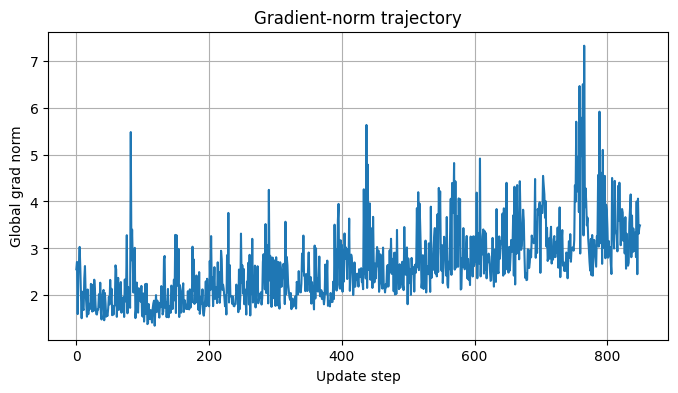

In [29]:
model.plot_grad_norms()

In [30]:
# model.fine_tune_cnn(train_ds, processor.val_data, layers_to_unfreeze=8, lr=1e-5, epochs=5)

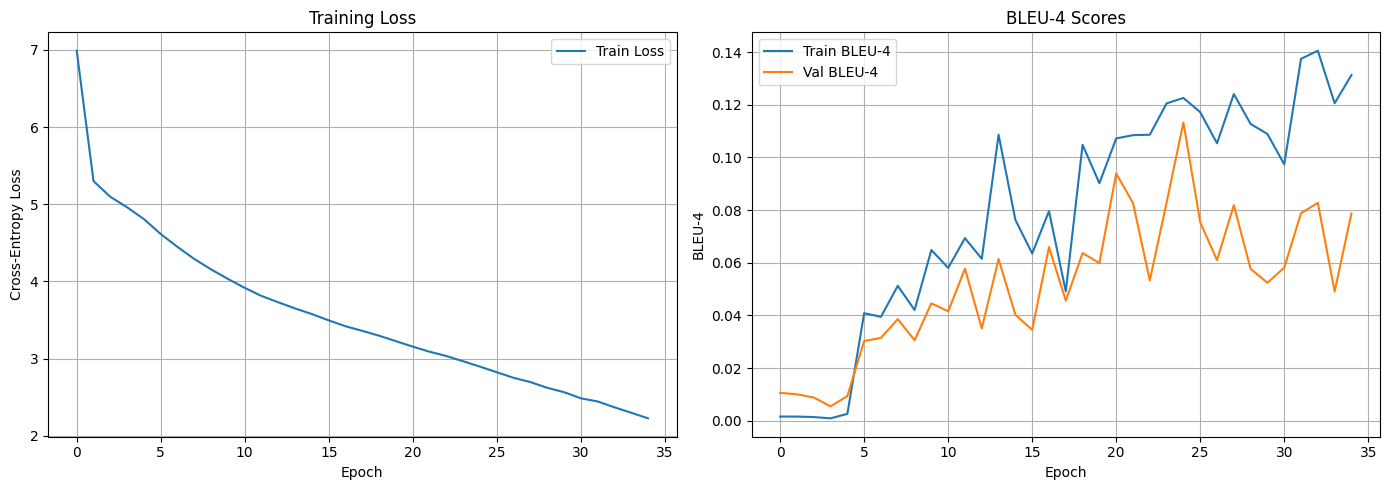

In [31]:
model.plot_history()

In [32]:
model.evaluate_bleu(processor.test_data)

100%|██████████| 100/100 [00:22<00:00,  4.49it/s]

BLEU-1: 0.5029
BLEU-2: 0.2934
BLEU-3: 0.1829
BLEU-4: 0.1238


{'bleu-1': 0.5029239766081871,
 'bleu-2': 0.29337385700090995,
 'bleu-3': 0.1828771129272863,
 'bleu-4': 0.12378632471833134}

In [33]:
samples = processor.train_data[:5]  # known to be from training set
for img_name, _ in samples:
    img_path = os.path.join(CONFIG['image_dir'], img_name)
    pred = model.greedy_decode(img_path)
    print("Predicted:", ' '.join(pred))
    print("Ground Truth:", processor.captions_dict[img_name][:1])

Predicted: a man in a white shirt and sunglasses is walking down a brick building with a building .
Ground Truth: ['A man in a military uniform is sitting at a desk speaking into a walkie-talkie .']
Predicted: a young girl in a white dress is standing on the camera .
Ground Truth: ['A big group of cowboys are trying to restrain five horses at a rodeo while the crowd in the background watches .']
Predicted: a man in a bight white shirt leaning down a pole .
Ground Truth: ['A man is partially silhouetted and leaning against a dark object .']
Predicted: a group of people playing a ball with the table .
Ground Truth: ['A large group of people that look korean riding on a train in the middle of the wilderness during the fall .']
Predicted: a man in a yellow shirt and a beanie , and a beanie , and a basket on the head .
Ground Truth: ['An elderly woman wearing a mocha-brown trench coat , white blouse , beads , and brown pants and is carrying a dark brown purse and gift bag is trying to flag 

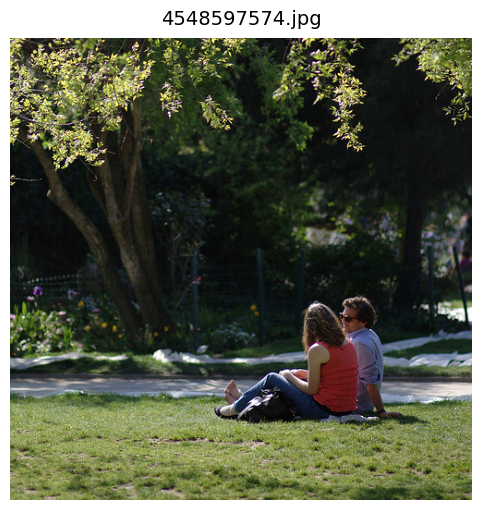

Ground-truth captions:
 - A man in a blue shirt and a woman in a red shirt sitting on the grass .
 - A man and a woman are sitting on the grass together .
 - A man and a woman are sitting on the grass .
 - A woman and a man sitting outside .
 - A couple sits in the grass .

Generated caption:
a man in a yellow shirt is sitting on the street .


Audio saved to caption_audio01.mp3


/tmp/ipykernel_87650/495922666.py:353: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  alpha_resized = Image.fromarray(np.uint8(255 * alpha)).resize((299, 299), resample=Image.BICUBIC)


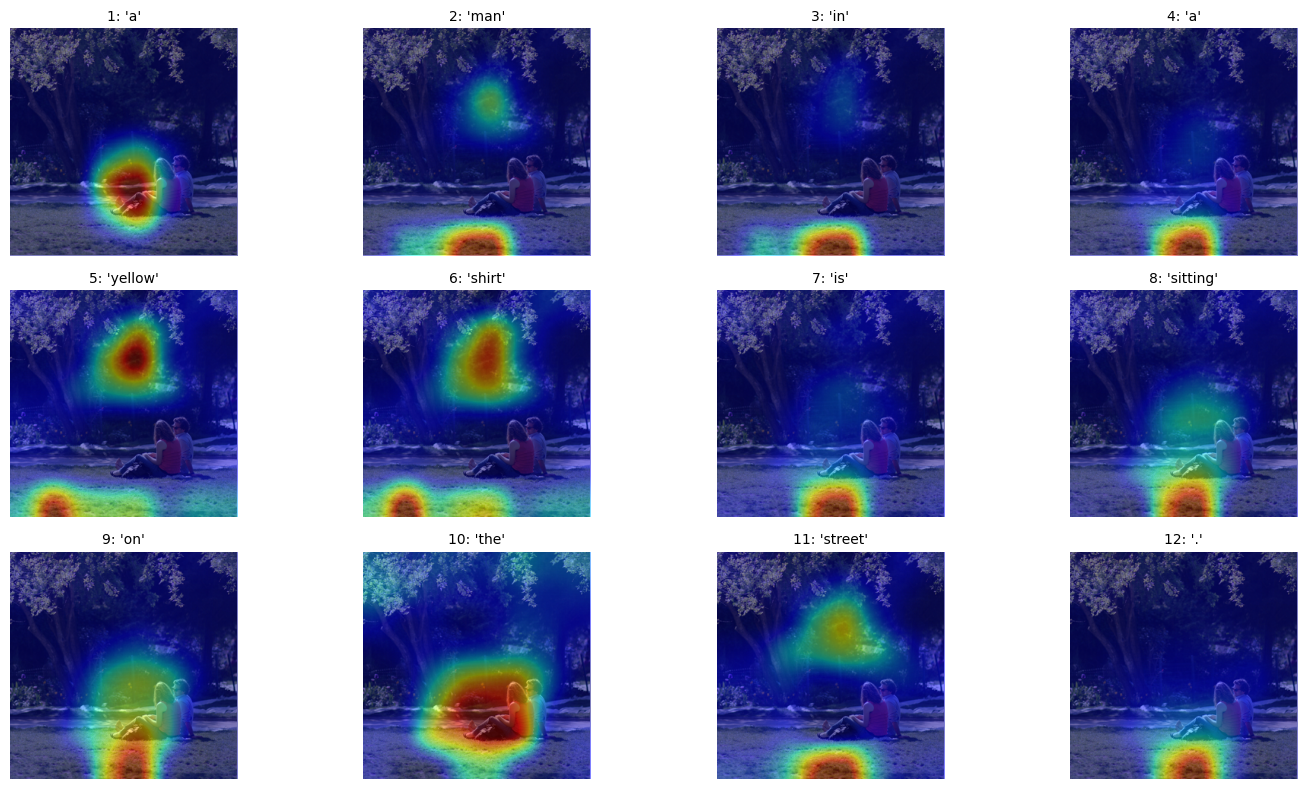

In [34]:
sample_pair = random.choice(processor.train_data)
sample_img = os.path.join(CONFIG['image_dir'], sample_pair[0])
model.demo(sample_img, filename='caption_audio01.mp3')

In [35]:
for batch in train_ds.take(1):
    img_tensor, tok_ids, _, filenames = batch
    fname = filenames[0].numpy().decode()

    decoded = ' '.join(
        processor.tokenizer.index_word.get(int(i), '')
        for i in tok_ids[0].numpy() if i)

    print("Filename :", fname)
    print("Caption  :", decoded)
    print("GT       :", processor.captions_dict[fname][0])

Filename : 3060594966.jpg
Caption  : <start> a small boy wearing a longsleeved shirt and slacks is walking outdoors . <end>
GT       : A young boy dressed in a suit concentrates on his footwork with a peace sign in the air .
